Đọc nhật ký giao dịch
Column = ["Broker", "Date", "Action", "Ticker", "Price", "Volume","Value", "Reason"]

In [1]:
import matplotlib

import pandas as pd
import numpy as np
import dateutil
import warnings
warnings.filterwarnings('ignore')

def transform(row):
    if row == 'BUY':
        return 1
    return -1
filename = r"D:\Excel File\Nhat_Ky_Giao_Dich.xlsx"
df= pd.read_excel(filename, sheet_name="nhatky", header=1, usecols="B:I", names = ["Broker", "Date", "Action", "Ticker", "Price", "Volume","Value", "Reason"])


# drop the row with all NaN
#df = df.dropna(how='all')
df['Action'] = df['Action'].apply((lambda x: transform(x)))
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
#df['Volume'] = df['Volume'].astype(int)
# filter date > 2021-01-01
df = df[df['Date'] > dateutil.parser.parse("2021-10-05")]

# accumulate the Volumn of each ticker by using Volumn = Volumn * Action
df['Volume'] = df['Volume'] * df['Action']

# group by Ticker and sum the Volumn, return data frame
df = df.groupby('Ticker').agg({'Volume': 'sum'})
df = df.sort_values(by='Volume', ascending=False)
df.reset_index(inplace=True)
df = df[df['Volume'] > 0]

porfolio = df


Download EOD data from CafeF (zip format)

In [2]:

# Get latest working date, include today if today is a working day (not weekend)
latest_working_date = pd.to_datetime('today')
if latest_working_date.hour < 16:
    latest_working_date = latest_working_date - pd.Timedelta(days=1)
    
if latest_working_date.weekday() == 5:
    latest_working_date = latest_working_date - pd.Timedelta(days=1)
elif latest_working_date.weekday() == 6:
    latest_working_date = latest_working_date - pd.Timedelta(days=2)
    

# convert to string ddmmYYYY, EOD only
print("latest_working_date: ", latest_working_date)
#https://cafef1.mediacdn.vn/data/ami_data/20240315/CafeF.SolieuGD.15032024.zip
url = "https://cafef1.mediacdn.vn/data/ami_data/{}/CafeF.SolieuGD.{}.zip".format(latest_working_date.strftime('%Y%m%d'), latest_working_date.strftime('%d%m%Y'))
print("url: ", url)


import requests
import zipfile
import os
import io
# download above zip file to local

filename = url.split("/")[-1]
folder = r"D:\Excel File\Stock Data"

# check if file exist or not, if not then download
if not os.path.exists(os.path.join(folder, filename)):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    # create folder if not exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    # store zip file to folder
    with open(os.path.join(folder, filename), 'wb') as f:
        print("store zip file")
        print("filename: ", filename)
        f.write(r.content)

    # list the folder
    print("list the folder")
    print(os.listdir(folder))
    z.extractall(folder)

    # remove file that have NN in the name
    for the_file in os.listdir(folder):
        if "NN" in the_file and "zip" not in the_file:
            file_path = os.path.join(folder, the_file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(e)
    # clean up zip file
    z.close()


# use pandas to merge all csv file in the folder to one file, csv file need to have the last working date dd.mm.YYYY in the name
import glob
import os
import pandas as pd
# get all csv file in the folder
all_files = glob.glob(os.path.join(folder, "*.csv"))
# for over each file and merge merge dataframe if the name contain the last working date 

df = pd.DataFrame()
header = ["Ticker", "Date", "Open", "High", "Low", "Close", "Volume"]
for filename in all_files:
    if latest_working_date.strftime('%d.%m.%Y') in filename:
        print("filename: ", filename)
        df = pd.concat([df, pd.read_csv(filename, header=0, names=header, parse_dates=True)], ignore_index=True)


# convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')
print(df.dtypes)
# filter latest date only
df = df[df['Date'] == np.max(df['Date'])]
print(df.head(5))

price = df


latest_working_date:  2024-03-18 23:30:10.959672
url:  https://cafef1.mediacdn.vn/data/ami_data/20240318/CafeF.SolieuGD.18032024.zip
store zip file
filename:  CafeF.SolieuGD.18032024.zip
list the folder
['CafeF.SolieuGD.18032024.zip', 'Upto']
filename:  D:\Excel File\Stock Data\CafeF.HNX.18.03.2024.csv
filename:  D:\Excel File\Stock Data\CafeF.HSX.18.03.2024.csv
filename:  D:\Excel File\Stock Data\CafeF.UPCOM.18.03.2024.csv
Ticker            object
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object
  Ticker       Date  Open  High   Low  Close  Volume
0    AAV 2024-03-18   3.8   3.9   3.7    3.8  422011
1    ADC 2024-03-18  19.6  20.9  19.6   19.9    5300
2    ALT 2024-03-18  13.8  14.4  13.4   14.4    1500
3    AMC 2024-03-18  17.2  17.2  17.0   17.0    2700
4    AME 2024-03-18   8.2   8.2   8.2    8.2     111


Draw Porforlio pie and bar chart

  Ticker  Volume  Close        Value
0    VIB  6900.0  22.25  153525000.0
1    VCG  5400.0  25.20  136080000.0
2    PVS  3200.0  36.80  117760000.0
3    DHC  3100.0  43.70  135470000.0
4    VCI  2900.0  51.70  149930000.0
5    IDC  2500.0  57.90  144750000.0


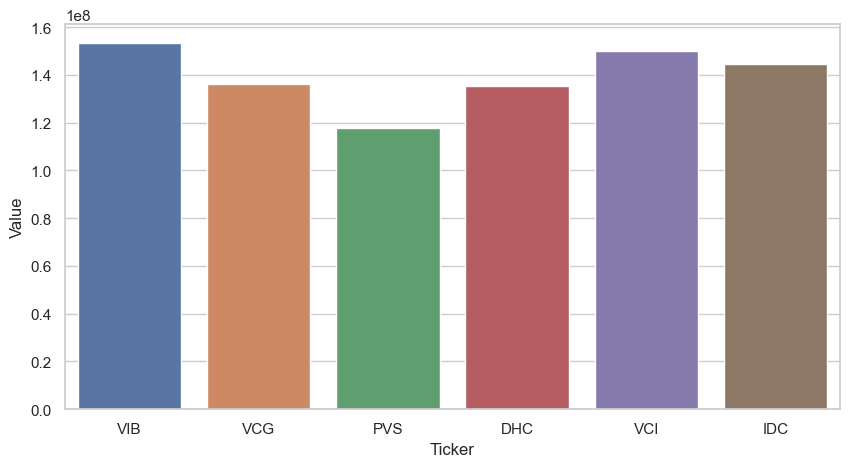

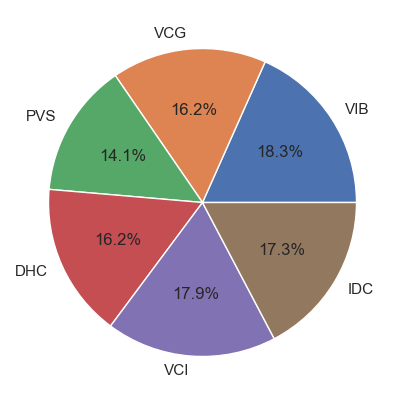

In [3]:
# merge porfolio and price by Ticker, return porfolio Volume and price Close
price = price[["Ticker", "Close"]]
df = pd.merge(porfolio, price, on='Ticker', how='left')
porfolio = df
#print(porfolio.head(5))
#df = porfolio

# use seaborn to plot the porfolio value by Ticker
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
df["Value"] = df["Volume"] * df["Close"] * 1000
print(df.head(10))
ax = sns.barplot(x="Ticker", y="Value", data=df)
plt.show()

# draw pie chart with nice style
plt.figure(figsize=(10, 5))
plt.pie(df["Value"], labels=df["Ticker"], autopct='%1.1f%%')
plt.show()


calculate daily return and draw history of the portfolio

In [6]:

filename = url.split("/")[-1]
folder = r"D:\Excel File\Stock Data\Upto"

# use pandas to merge all csv file in the folder to one file, csv file need to have the last working date dd.mm.YYYY in the name
import glob
import os
import pandas as pd
# get all csv file in the folder
all_files = glob.glob(os.path.join(folder, "*.csv"))
# for over each file and merge merge dataframe if the name contain the last working date 
print("latest_working_date: ", latest_working_date)
#https://cafef1.mediacdn.vn/data/ami_data/20240318/CafeF.SolieuGD.Upto18032024.zip
url = "https://cafef1.mediacdn.vn/data/ami_data/{}/CafeF.SolieuGD.Upto{}.zip".format(latest_working_date.strftime('%Y%m%d'), latest_working_date.strftime('%d%m%Y'))
print("url: ", url)

df = pd.DataFrame()
header = ["Ticker", "Date", "Open", "High", "Low", "Close", "Volume"]
for filename in all_files:
    if latest_working_date.strftime('%d.%m.%Y') in filename:
        print("filename: ", filename)
        df = pd.concat([df, pd.read_csv(filename, header=0, names=header, parse_dates=True)], ignore_index=True)
        
# convert Date to datetime

df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')
print(df.dtypes)
print("max date and min date: ", np.max(df['Date']), np.min(df['Date']))

# filter date >= 20230101 and Ticker is in my portfolio

df = df[df['Date'] >= dateutil.parser.parse("2023-10-30")]
df = df[df['Ticker'].isin(porfolio['Ticker'])]


# sort by date
df = df.sort_values(by='Date', ascending=True)
print(df.head(3))

# calculate daily return for each ticker

df['Return'] = df.groupby('Ticker')['Close'].pct_change() * 100
print(df.tail(3))

def draw_return_historgram(ticker):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[df['Ticker'] == ticker]['Return'], label=ticker)
    plt.legend()
    plt.show()

latest_working_date:  2024-03-18 23:30:10.959672
url:  https://cafef1.mediacdn.vn/data/ami_data/20240318/CafeF.SolieuGD.Upto18032024.zip


KeyError: 'Date'

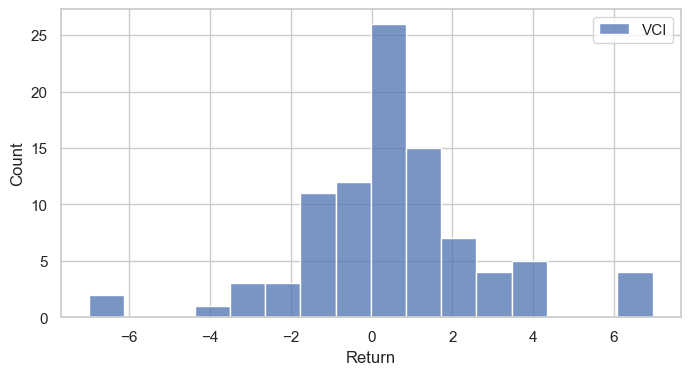

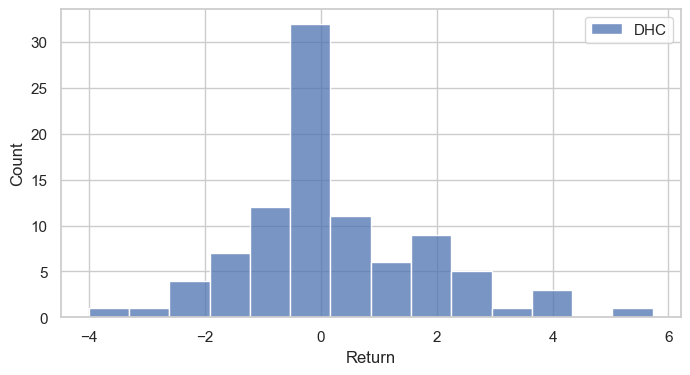

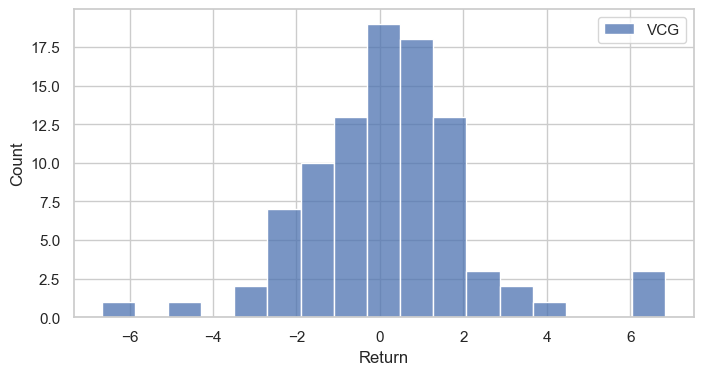

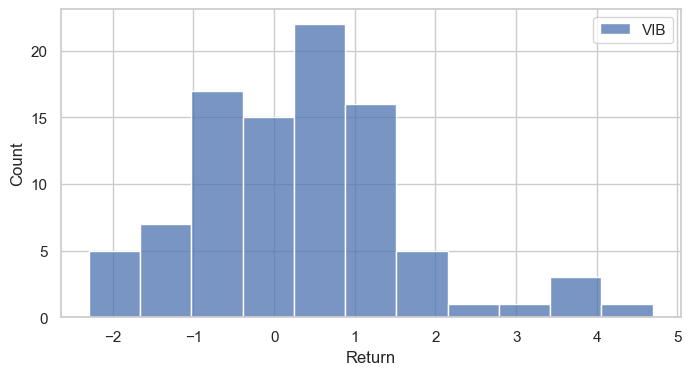

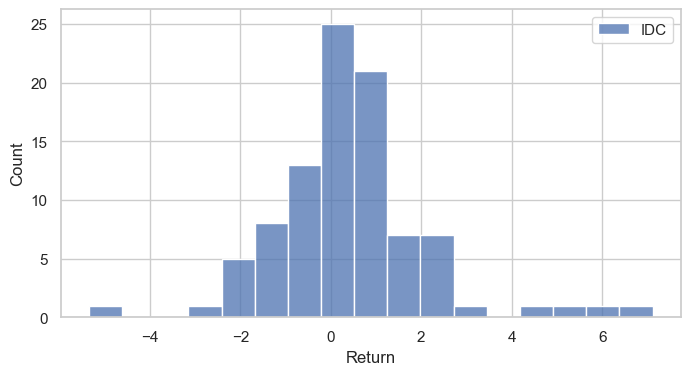

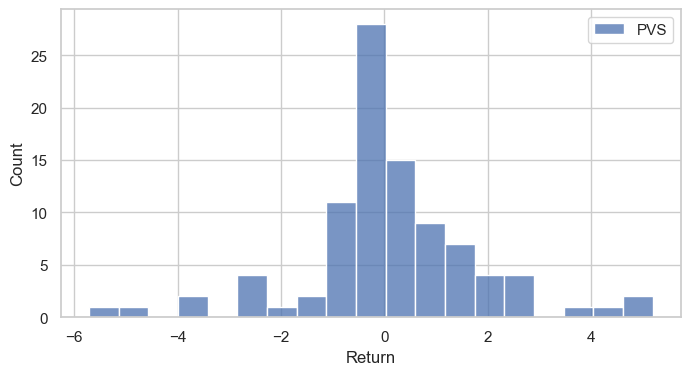

In [ ]:
draw_return_historgram("VCI")
draw_return_historgram("DHC")
draw_return_historgram("VCG")
draw_return_historgram("VIB")
draw_return_historgram("IDC")
draw_return_historgram("PVS")

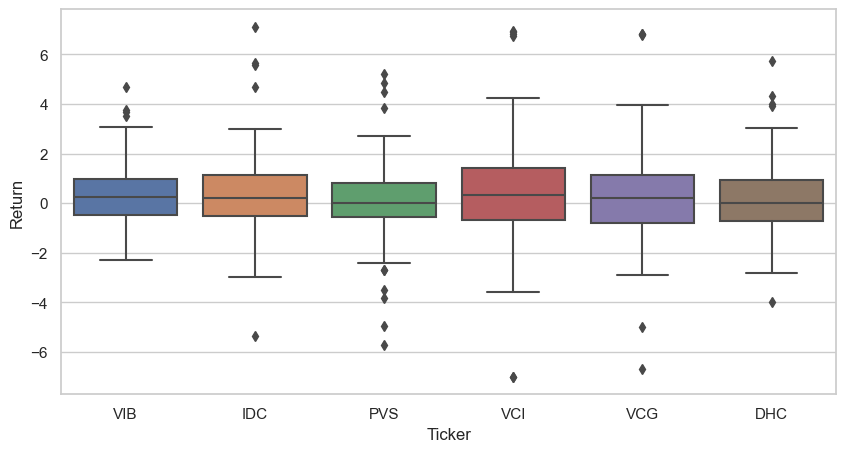

In [ ]:
# draw box plot with nice style of each ticker and return
plt.figure(figsize=(10, 5))
sns.boxplot(x='Ticker', y='Return', data=df)
plt.show()

            mean       std    median
Ticker                              
VCI     0.486966  2.349613  0.342857
IDC     0.381429  1.743908  0.195312
VIB     0.303301  1.295342  0.261097
VCG     0.241043  2.037482  0.202020
DHC     0.214423  1.582334  0.000000
PVS     0.100612  1.739355  0.000000
            mean       std    median    Weight
Ticker                                        
DHC     0.214423  1.582334  0.000000  0.124104
IDC     0.381429  1.743908  0.195312  0.220763
PVS     0.100612  1.739355  0.000000  0.058232
VCG     0.241043  2.037482  0.202020  0.139511
VCI     0.486966  2.349613  0.342857  0.281846
VIB     0.303301  1.295342  0.261097  0.175545


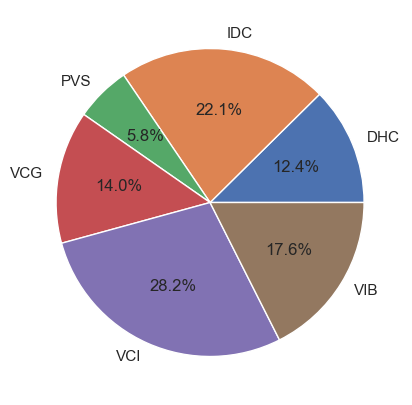

In [ ]:
# calculate the mean and std of daily return for each ticker

mean_return = df.groupby('Ticker')['Return'].agg(['mean', 'std', 'median'])
# what is the best ticker in my portfolio?
print(mean_return.sort_values(by='mean', ascending=False))

# based on how best tickers are, how to allocate money to each stock in the porfolio in percentage
# use the mean_return to calculate the weight for each ticker, then plot it
mean_return['Weight'] = mean_return['mean'] / mean_return['mean'].sum()
print(mean_return)

plt.figure(figsize=(10, 5))
plt.pie(mean_return['Weight'], labels=mean_return.index, autopct='%1.1f%%')
plt.show()



Predict future performance

In [ ]:
import math
# I want to allocate 170 value to my porfolio
# calculate how much volume of each stock (100 in batch) to make the total value of each stock in the porfolio equaly distributed 
# then plot it
new_value = 170000000
total_value_per_ticket = (porfolio['Value'].sum() + new_value) / len(porfolio)
print(len(porfolio))
print("total current value: ", porfolio['Value'].sum())
print("total_value_per_ticket: ", total_value_per_ticket)
porfolio['VolumeDelta'] = (total_value_per_ticket - porfolio['Value'])/(porfolio['Close'] * 1000)
#print(porfolio)
# round to nearest 100 that less than VolumeDelta, example:  1234 => 1200, 1256 => 1200, 1111 => 1100
porfolio['VolumeDelta'] = porfolio['VolumeDelta'].apply(lambda x: math.floor(x / 100) * 100)
#print(porfolio)

porfolio['VolumeAfter'] = porfolio['VolumeDelta'] + porfolio['Volume']
porfolio['ValueAfter'] = porfolio['VolumeAfter'] * porfolio['Close'] * 1000
porfolio['TotalBuy'] = porfolio['VolumeDelta'] * porfolio['Close'] * 1000
print(porfolio)



6
total current value:  785325000.0
total_value_per_ticket:  159220833.33333334
  Ticker  Volume  Close        Value  VolumeDelta  VolumeAfter   ValueAfter  \
0    VIB  6400.0  22.50  144000000.0          600       7000.0  157500000.0   
1    VCG  5300.0  24.55  130115000.0         1100       6400.0  157120000.0   
2    PVS  3100.0  37.90  117490000.0         1100       4200.0  159180000.0   
3    DHC  2800.0  45.90  128520000.0          600       3400.0  156060000.0   
4    VCI  2600.0  53.70  139620000.0          300       2900.0  155730000.0   
5    IDC  2100.0  59.80  125580000.0          500       2600.0  155480000.0   

     TotalBuy  
0  13500000.0  
1  27005000.0  
2  41690000.0  
3  27540000.0  
4  16110000.0  
5  29900000.0  
